In [3]:
import pandas as pd

df = pd.read_csv("supplementary_data/compare_matrices.csv")

In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


def analyze_synaptic_agreement(df):
    """
    Analyze the agreement between trained and refined synaptic weights,
    focusing on inhibitory connections.

    Parameters:
    df: pandas DataFrame with columns 'trained' and 'refined'

    Returns:
    dict with various metrics and analysis results
    """
    # Create masks for different categories
    trained_inhibitory = df["trained"] < 0
    refined_inhibitory = df["refined"] < 0

    # Basic agreement metrics
    inhibitory_agreement = trained_inhibitory == refined_inhibitory
    agreement_rate = inhibitory_agreement.mean()

    # Detailed analysis of different cases
    true_positives = (trained_inhibitory & refined_inhibitory).sum()
    false_positives = (trained_inhibitory & ~refined_inhibitory).sum()
    false_negatives = (~trained_inhibitory & refined_inhibitory).sum()
    true_negatives = (~trained_inhibitory & ~refined_inhibitory).sum()

    total_synapses = len(df)

    # Calculate Matthews Correlation Coefficient
    mcc = matthews_corrcoef(trained_inhibitory, refined_inhibitory)

    # Calculate weight correlation for matching inhibitory synapses
    matching_inhibitory_mask = trained_inhibitory & refined_inhibitory
    weight_correlation = stats.pearsonr(
        df.loc[matching_inhibitory_mask, "trained"],
        df.loc[matching_inhibitory_mask, "refined"],
    )[0]

    # Calculate average strength comparison
    avg_trained_strength = df.loc[trained_inhibitory, "trained"].mean()
    avg_refined_strength = df.loc[refined_inhibitory, "refined"].mean()

    return {
        "agreement_rate": agreement_rate,
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "true_negatives": true_negatives,
        "total_synapses": total_synapses,
        "matthews_correlation": mcc,
        "weight_correlation": weight_correlation,
        "avg_trained_strength": avg_trained_strength,
        "avg_refined_strength": avg_refined_strength,
    }


def matthews_corrcoef(x, y):
    """
    Calculate Matthews Correlation Coefficient for binary variables
    """
    tp = np.sum(x & y)
    tn = np.sum(~x & ~y)
    fp = np.sum(x & ~y)
    fn = np.sum(~x & y)

    numerator = tp * tn - fp * fn
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / denominator if denominator != 0 else 0


def generate_report(df):
    """
    Generate a comprehensive analysis report

    Parameters:
    df: pandas DataFrame with columns 'trained' and 'refined'

    Returns:
    str: formatted report
    """
    results = analyze_synaptic_agreement(df)

    # Calculate percentages for confusion matrix
    total = results["total_synapses"]
    tp_pct = results["true_positives"] / total * 100
    fp_pct = results["false_positives"] / total * 100
    fn_pct = results["false_negatives"] / total * 100
    tn_pct = results["true_negatives"] / total * 100

    report = f"""Synaptic Weight Agreement Analysis Report
=======================================

Overall Agreement Metrics:
------------------------
Agreement Rate: {results['agreement_rate']:.2%}
Matthews Correlation Coefficient: {results['matthews_correlation']:.3f}
Weight Correlation (matching inhibitory): {results['weight_correlation']:.3f}

Confusion Matrix (percentages):
---------------------------
Total Synapses: {total:,} (100%)

                   Actually Inhibitory    Actually Excitatory
Predicted Inhib    {tp_pct:6.2f}% ({results['true_positives']:,})    {fp_pct:6.2f}% ({results['false_positives']:,})
Predicted Excit    {fn_pct:6.2f}% ({results['false_negatives']:,})    {tn_pct:6.2f}% ({results['true_negatives']:,})

Model predicts inhibitory: {(tp_pct + fp_pct):.2f}%
Biological inhibitory: {(tp_pct + fn_pct):.2f}%

Strength Analysis:
----------------
Average Trained Inhibitory Strength: {results['avg_trained_strength']:.3f}
Average Refined Inhibitory Strength: {results['avg_refined_strength']:.3f}
Strength Ratio (Trained/Refined): {results['avg_trained_strength']/results['avg_refined_strength']:.3f}
"""
    return report

In [17]:
results = analyze_synaptic_agreement(df)
print(generate_report(df))

/tmp/ipykernel_271222/2789365337.py:73: RuntimeWarning: overflow encountered in scalar multiply
  denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


Synaptic Weight Agreement Analysis Report

Overall Agreement Metrics:
------------------------
Agreement Rate: 50.02%
Matthews Correlation Coefficient: 7.913
Weight Correlation (matching inhibitory): 0.862

Confusion Matrix (percentages):
---------------------------
Total Synapses: 15,091,983 (100%)

                   Actually Inhibitory    Actually Excitatory
Predicted Inhib     20.42% (3,081,363)     29.59% (4,466,233)
Predicted Excit     20.39% (3,077,020)     29.60% (4,467,367)

Model predicts inhibitory: 50.01%
Biological inhibitory: 40.81%

Strength Analysis:
----------------
Average Trained Inhibitory Strength: -1.568
Average Refined Inhibitory Strength: -3.605
Strength Ratio (Trained/Refined): 0.435



In [14]:
def fast_plot_comparison(df, sample_size=100000):
    """
    Create faster visualizations using sampling
    """
    # Sample the data
    sample_df = df.sample(n=min(sample_size, len(df)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Scatter plot with hexbin for density
    axes[0].hexbin(
        sample_df["refined"], sample_df["trained"], gridsize=50, cmap="viridis"
    )
    axes[0].set_xlabel("Refined Weights")
    axes[0].set_ylabel("Trained Weights")
    axes[0].set_title("Weight Comparison (Sampled)")
    axes[0].set_xlim(-100, 100)
    axes[0].set_ylim(-100, 100)

    # Distribution comparison (inhibitory only)
    trained_inhib = sample_df["trained"][sample_df["trained"] < 0]
    refined_inhib = sample_df["refined"][sample_df["refined"] < 0]

    axes[1].hist(
        [trained_inhib, refined_inhib], bins=50, label=["Trained", "Refined"], alpha=0.5
    )
    axes[1].set_xlim(-25, 25)
    axes[1].set_xlabel("Weight Value")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Inhibitory Weights Distribution")
    axes[1].legend()

    plt.tight_layout()
    return fig

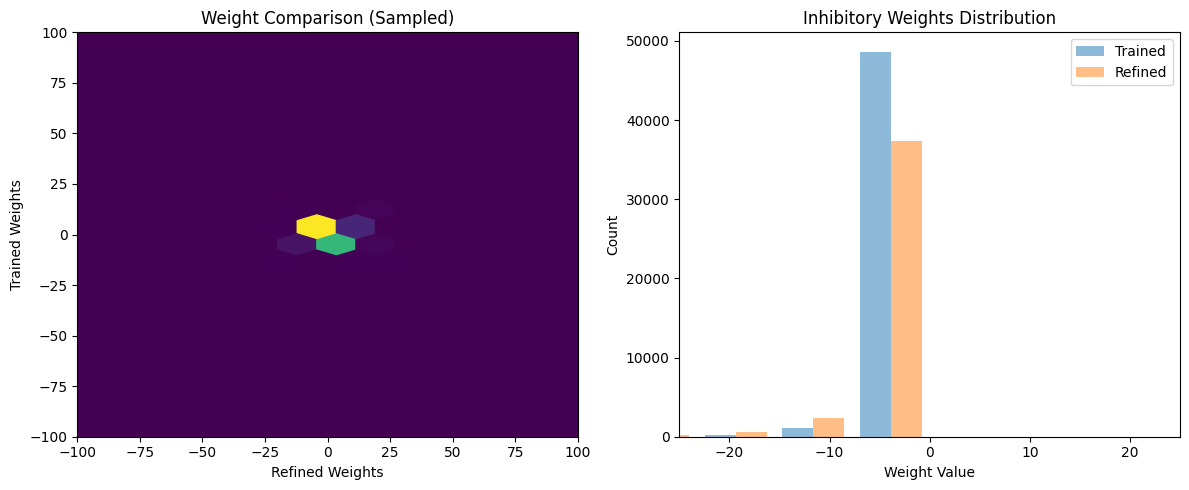

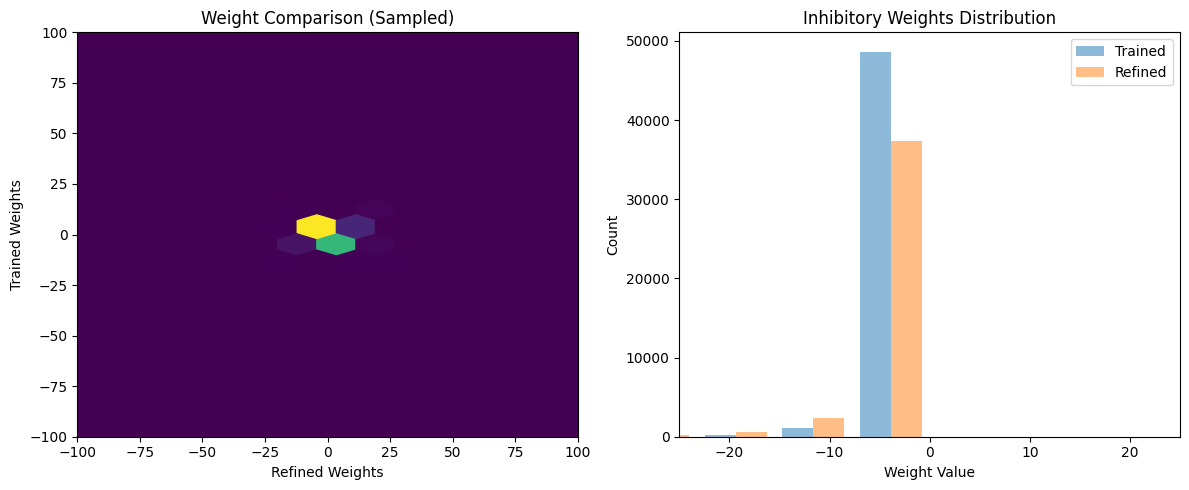

In [15]:
plt.close("all")
fast_plot_comparison(df)

In [11]:
# check how many positive and negative values are in both columns of df
print(df["trained"].apply(lambda x: 1 if x < 0 else 0).value_counts())
print(df["refined"].apply(lambda x: 1 if x < 0 else 0).value_counts())

trained
1    7547596
0    7544387
Name: count, dtype: int64
refined
0    8933600
1    6158383
Name: count, dtype: int64
